In [1]:
import timeit
import h5py
import util
import glob
import math
import threading
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import img_as_float
from time import sleep

%matplotlib inline
%load_ext autoreload

In [2]:
#async func to load img data
def read_data_batch(filename):
    capture_file = h5py.File(filename, "r")
   
    if(capture_file is None or not util.is_valid_capture_file(capture_file)):
        raise ValueError(filename + " is not valid!")

    print('Reading data: ', capture_file.attrs['count'])

    count = capture_file.attrs['count']
    img_size = capture_file.attrs['img_size']
   
    img_data = np.empty((count, img_size[0], img_size[1], img_size[2]), dtype=np.float32)
    input_data = np.empty((count, 9), dtype=np.float32)
    
    for i in range(count):
        img_data[i] = np.array(capture_file['images'][i], dtype='float32').reshape((img_size[0], img_size[1], img_size[2])) 
        img_data[i] = img_data[i] * 1.0 / 255.0 + 0.5 / 255.0
        
        input_data[i] = np.array(capture_file['input'][i], dtype='float32')
    
    capture_file.close()
    
    return img_data, input_data

In [13]:
def load_and_enqueue(session, coord, filenames, num_epochs):
    #if(coord.should_stop()):
    np.random.shuffle(filenames) 
    i = 0
    epoch = 0
    stop = False
    while not coord.should_stop(): 
        file = filenames[i]
        print('Reading file: ', file)
        img_data, ctrl_data = read_data_batch(file)
        i += 1
        
        session.run(enqueue_op, feed_dict={img_batch_input: img_data,
                                           ctrl_batch_input: ctrl_data})
        
        if i == len(filenames):
            epoch += 1
            print('EPOCH END: ', epoch)
            i = 0
            if epoch == num_epochs:
                print('Requesting stop')
                coord.request_stop()
                
        sleep(0.1)
        
    
    #ession.run(q.close());
    print('Closing')

In [14]:
#cnn architecture
def cnn_arch(X, reuse_weights=False):
    conv1 = tf.layers.conv2d(inputs=X,filters=16,kernel_size=7, padding="same", 
                             strides = 2, activation=tf.nn.relu, name='init_conv', reuse=reuse_weights)
    #print(conv1)
    #batch1 = tf.layers.batch_normalization(inputs=conv1, training=is_training)
    conv2 = tf.layers.conv2d(inputs=conv1,filters=24,kernel_size=7, padding="same", 
                             strides = 2, activation=tf.nn.relu, name='conv2', reuse=reuse_weights)
    print(conv2)
    conv3 = tf.layers.conv2d(inputs=conv2,filters=36,kernel_size=7, padding="same", 
                             strides = 2, activation=tf.nn.relu, name='conv3', reuse=reuse_weights)
    print(conv3)
    conv4 = tf.layers.conv2d(inputs=conv3,filters=48,kernel_size=7, padding="same", 
                             strides = 2, activation=tf.nn.relu, name='conv4', reuse=reuse_weights)
    print(conv4)
    conv5 = tf.layers.conv2d(inputs=conv4,filters=64,kernel_size=5, padding="same", 
                             strides = 1, activation=tf.nn.relu, name='conv5', reuse=reuse_weights)
    print(conv5)
    conv6 = tf.layers.conv2d(inputs=conv5,filters=64,kernel_size=5, padding="same", 
                             strides = 1, activation=tf.nn.relu, name='conv6', reuse=reuse_weights)
    print(conv6)
    last_layer = conv6
    x, w, h, d = last_layer.get_shape().as_list()
    print(w*h*d)
    last_flat = tf.reshape(last_layer, [-1, w*h*d])
    
    fc0 = tf.layers.dense(inputs=last_flat, units=1024, activation=tf.nn.relu, name='fc0', reuse=reuse_weights)  
    fc1 = tf.layers.dense(inputs=fc0, units=100, activation=tf.nn.relu, name='fc1', reuse=reuse_weights)
    fc2 = tf.layers.dense(inputs=fc1, units=50, activation=tf.nn.relu, name='fc2', reuse=reuse_weights)
    fc3 = tf.layers.dense(inputs=fc2, units=9, activation=None, name='fc3', reuse=reuse_weights)
    
    return fc3

In [15]:
def define_model(X, y, learning_rate):
    
    y_out = cnn_arch(X)
    cost = tf.losses.mean_squared_error(labels=y,predictions=y_out)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(cost)
    
    conv_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'init_conv')[0]
    weights_transposed = tf.transpose (conv_weights, [3, 0, 1, 2])
    tf.summary.image('cnn_0_layer', weights_transposed, max_outputs=16)
    tf.summary.histogram('cnn_0_hist', conv_weights)
    with tf.name_scope('train'):
        tf.summary.scalar("cost", cost)
        tf.summary.scalar('learning_rate', learning_rate)

    # batch normalization in tensorflow requires this extra dependency
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        train = optimizer.minimize(cost)
        
    return train

In [16]:
from time import sleep

tf.reset_default_graph()

BATCH_SIZE = 64
NUM_EPOCHS = 1
INIT_LEARNING_RATE = 0.001

img_batch_input = tf.placeholder(tf.float32, shape=[None, 215, 310, 3], name="image_train_batch")
ctrl_batch_input = tf.placeholder(tf.float32, shape=[None, 9])

is_training = tf.placeholder(tf.bool)

min_after_dequeue = 2000
capacity = min_after_dequeue + 3 * BATCH_SIZE
q = tf.RandomShuffleQueue(capacity, min_after_dequeue=min_after_dequeue, 
                          dtypes=[tf.float32, tf.float32], shapes=[[215, 310, 3], [9]])
enqueue_op = q.enqueue_many([img_batch_input, ctrl_batch_input])
X_batch, y_batch = q.dequeue_up_to(BATCH_SIZE)

X_eval = tf.placeholder(tf.float32, shape=[None, 215, 310, 3], name="image_eval")

learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

net = define_model(X_batch, y_batch, learning_rate)
eval_net = cnn_arch(X_eval, reuse_weights = True)

tf.add_to_collection('model', X_eval)
tf.add_to_collection('model', eval_net)

Tensor("conv2/Relu:0", shape=(?, 54, 78, 24), dtype=float32)
Tensor("conv3/Relu:0", shape=(?, 27, 39, 36), dtype=float32)
Tensor("conv4/Relu:0", shape=(?, 14, 20, 48), dtype=float32)
Tensor("conv5/Relu:0", shape=(?, 14, 20, 64), dtype=float32)
Tensor("conv6/Relu:0", shape=(?, 14, 20, 64), dtype=float32)
17920
Tensor("conv2_2/Relu:0", shape=(?, 54, 78, 24), dtype=float32)
Tensor("conv3_2/Relu:0", shape=(?, 27, 39, 36), dtype=float32)
Tensor("conv4_2/Relu:0", shape=(?, 14, 20, 48), dtype=float32)
Tensor("conv5_2/Relu:0", shape=(?, 14, 20, 64), dtype=float32)
Tensor("conv6_2/Relu:0", shape=(?, 14, 20, 64), dtype=float32)
17920


In [17]:
#training cell
global_coord = tf.train.Coordinator()

sess = tf.Session()

filenames = glob.glob('capture/*.hdf5')
enqueue_threads = [threading.Thread(target=load_and_enqueue, args=(sess,global_coord, filenames, NUM_EPOCHS), daemon=True) for i in range(1)]
for t in enqueue_threads:
    t.start()

writer = tf.summary.FileWriter('logs/', graph=sess.graph)
summary_op = tf.summary.merge_all()

sess.run(tf.group(tf.local_variables_initializer() ,tf.global_variables_initializer()))
step = 0
try:
    while not global_coord.should_stop():
        step += 1
        lr = INIT_LEARNING_RATE
        is_t = True
        print('Iter: ', step)
        _, summary = sess.run([net, summary_op], feed_dict={learning_rate: lr, is_training:is_t})
        if(step % 5 == 0):
            writer.add_summary(summary, step)
        sleep(0.1)
except tf.errors.OutOfRangeError:
    print('Done training - epoch limit reached.')
finally:
    global_coord.request_stop()

#print(sess.run(q.size()))
#sess.run(q.close(cancel_pending_enqueues=True))
global_coord.request_stop()
global_coord.join(enqueue_threads)

writer.flush()
writer.close()

Reading file:  capture\a2345fba50bb4a209cc3222e8c7b31fe.hdf5
Reading data:  3344
Iter:  1
Iter:  2
Iter:  3
Iter:  4
Iter:  5
Iter:  6
Iter:  7
Iter:  8
Iter:  9
Iter:  10
Iter:  11
Iter:  12
Iter:  13
Iter:  14
Iter:  15
Iter:  16
Iter:  17
Iter:  18
EPOCH END:  1
Requesting stop
Closing


In [8]:
# save model
saver = tf.train.Saver()
save_path = saver.save(sess, "./cnn_model")
save_meta = saver.export_meta_graph(filename='tf_cnn.meta')

3.12 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[[ 0.03703743  0.16717491  0.02713624 -0.00472149  0.06163244 -0.03566141
   0.02940669 -0.2156058  -0.63557816]]


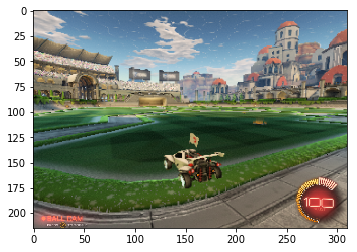

In [11]:
#model test
from scipy import ndimage
from skimage import img_as_float
im = img_as_float(ndimage.imread('data/scr_5.png'))
plt.imshow(im)
im = im.reshape((1,) + im.shape)
%timeit sess.run(eval_net, feed_dict = {X_eval: im})
print(sess.run(eval_net, feed_dict = {X_eval: im}))

In [12]:
#loaded model test
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('cnn_model.meta')
    new_saver.restore(sess, './cnn_model')
    cnn_out = tf.get_collection('model')[1]
    cnn_in = tf.get_collection('model')[0]
    print(cnn_in)
    print(cnn_out)
    print(sess.run(cnn_out, feed_dict = {cnn_in: im }))

Tensor("image_eval:0", shape=(?, 215, 310, 3), dtype=float32)
Tensor("fc3_2/BiasAdd:0", shape=(?, 9), dtype=float32)
[[ 0.03703743  0.16717491  0.02713624 -0.00472149  0.06163244 -0.03566141
   0.02940669 -0.2156058  -0.63557816]]
